In [52]:
# library imports
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Bestbuy specifics
import bby
import bby.util as ut

from bby.util import clean_doc, tb_enrich, nps_cleanstring
from bby.util import detokenize

import nltk
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import text_to_word_sequence

from skmultilearn.model_selection import iterative_train_test_split

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

null_str = "xyxyxz"


ModuleNotFoundError: No module named 'tensorflow_hub'

In [43]:
# Now get the comment into a form suitable for tokenizing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(text_to_word_sequence(sentence))
    return

def str_it(_ls):
    ls = str(_ls)
    word_tokens = word_tokenize(ls)
    ls = [w for w in word_tokens]

    ls = " ".join(ls)
    return ls

def write_txt_files(sentencelist, prefix='nps'):
    lc = 1
    print(f'Writing: {len(sentencelist)} files...')
    for item in sentencelist:
        outfilename = f'{prefix}_{lc}.txt'
        try:
            outfile = open(outfilename, 'w')
        except OSError as error:
            print(f'Cannot create file: {outfilename}. Failed with error: {error}! Exiting')
            return
        outfile.write(item)
        outfile.write('\n')
        lc += 1
    outfile.close()
    return

def iterative_train_test_split_dataframe(X, y, test_size):
    df_index = np.expand_dims(X.index.to_numpy(), axis=1)
    X_train, y_train, X_test, y_test = iterative_train_test_split(df_index, y, test_size = test_size)
    X_train = X.loc[X_train[:,0]]
    X_test = X.loc[X_test[:,0]]
    return X_train, y_train, X_test, y_test

In [44]:
# create directories for train/test split of nps data in the format needed by
# keras read_text_dataset
#

def write_NPS_text_dataset(input_filename, rootpath='npsdata', frac=0.2):
    curr_dir = os.getcwd()
    data_dir = "/users/suchanek/repos/npsml/data/clean"
    os.chdir(data_dir)
    class_list = ['detractor', 'passive', 'promoter']

    # try to read the input file
    try:
        os.path.exists(input_filename)
    except OSError as error:
        print(error)
        print(f'Cant read input file {input_filename}. Fatal, exiting')
        return
    
    NPS_df = pd.read_csv(input_filename, index_col='respid2')
    
    # make the train and test subdirs for trainpath and testpath
    trainpath = os.path.join(rootpath,'train')
    testpath = os.path.join(rootpath,'test')
    # print(f'train: {trainpath}, test: {testpath}')

    # remove the entire tree first
    try:
        os.chdir(data_dir)
        shutil.rmtree(rootpath)
    except OSError as error:
        print(error)

    try: 
        os.makedirs(trainpath) 
    except OSError as error: 
        print(error)  

    try: 
        os.makedirs(testpath) 
    except OSError as error: 
        print(error)  
    
    # now make the class subdirectories for training and testing
    os.chdir(data_dir)
    os.chdir(trainpath)
    for cls in class_list:
        os.mkdir(cls)
    
    os.chdir(data_dir)
    os.chdir(testpath)
    for cls in class_list:
        os.mkdir(cls)
    
    prom_list_mask = NPS_df['NPS_Code'] == 2
    pass_list_mask = NPS_df['NPS_Code'] == 1
    det_list_mask = NPS_df['NPS_Code'] == 0

    # nps_list = NPS_df['NPSCommentCleaned'].apply(str_it)

    prom_list = NPS_df[prom_list_mask]
    pass_list = NPS_df[pass_list_mask]
    det_list = NPS_df[det_list_mask]

    prom_list_len = prom_list.shape[0]
    pass_list_len = pass_list.shape[0]
    det_list_len = det_list.shape[0]

    len_list = [prom_list_len, pass_list_len, det_list_len]
    print (f'Overall Distribution: Promoters: {prom_list_len}, Passives: {pass_list_len}, Detractors: {det_list_len}')

    shortest = np.argmin(len_list)
    sample_size = int(np.round(len_list[shortest] * frac))
    print(sample_size)

    prom_sample_size = int(np.round(prom_list_len * frac))
    pass_sample_size = int(np.round(pass_list_len * frac))
    det_sample_size = int(np.round(det_list_len * frac))

    # these subsets represent the test subset
    prom_list_test = prom_list.sample(sample_size)
    pass_list_test = pass_list.sample(sample_size)
    det_list_test = det_list.sample(sample_size)

    prom_list_train = prom_list[~prom_list.apply(tuple,1).isin(prom_list_test.apply(tuple, 1))]
    pass_list_train = pass_list[~pass_list.apply(tuple,1).isin(pass_list_test.apply(tuple, 1))]
    det_list_train = det_list[~det_list.apply(tuple,1).isin(det_list_test.apply(tuple, 1))]

    prom_train_sent = prom_list_train['NPSCommentCleaned'].apply(str_it)
    prom_test_sent = prom_list_test['NPSCommentCleaned'].apply(str_it)

    pass_train_sent = pass_list_train['NPSCommentCleaned'].apply(str_it)
    pass_test_sent = pass_list_test['NPSCommentCleaned'].apply(str_it)

    det_train_sent = det_list_train['NPSCommentCleaned'].apply(str_it)
    det_test_sent = det_list_test['NPSCommentCleaned'].apply(str_it)

    print(f'Promoters:')
    print(f'Training size: {prom_list_train.shape[0]}')
    print(f'Testing size {prom_list_test.shape[0]}')
    print(f'Original size: {prom_list.shape[0]}')
        
    print(f'\nPassives:')
    print(f'Training size: {pass_list_train.shape[0]}')
    print(f'Testing size {pass_list_test.shape[0]}')
    print(f'Original size: {pass_list.shape[0]}')
    
    print(f'\nDetractors:')
    print(f'Training size: {det_list_train.shape[0]}')
    print(f'Testing size {det_list_test.shape[0]}')
    print(f'Original size: {det_list.shape[0]}')
    
    # Checking balance of target classes after equalization
    sentiments = list(NPS_df["NPS® Breakdown"].unique())
    sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]

    print (f'Overall Distribution: Promoters: {prom_list_len}, Passives: {pass_list_len}, Detractors: {det_list_len}')
    plt.bar(sentiments, sentiment_nums)

    # now write the training files by class
    os.chdir(data_dir)
    os.chdir(trainpath)
    os.chdir('promoter')
    write_txt_files(prom_train_sent)
    os.chdir('..')
    os.chdir('passive')
    write_txt_files(pass_train_sent)
    os.chdir('..')
    os.chdir('detractor')
    write_txt_files(det_train_sent)
    
    # now write testing files by class
    os.chdir(data_dir)
    os.chdir(testpath)
    os.chdir('promoter')
    write_txt_files(prom_test_sent)
    os.chdir('..')
    os.chdir('passive')
    write_txt_files(pass_test_sent)
    os.chdir('..')
    os.chdir('detractor')
    write_txt_files(det_test_sent)
    
    os.chdir(curr_dir)
    return
    

In [45]:
# print(f'current: {os.getcwd()}')
# os.listdir()

Overall Distribution: Promoters: 10131, Passives: 8881, Detractors: 11381
1776
Promoters:
Training size: 8352
Testing size 1776
Original size: 10131

Passives:
Training size: 7105
Testing size 1776
Original size: 8881

Detractors:
Training size: 9605
Testing size 1776
Original size: 11381
Overall Distribution: Promoters: 10131, Passives: 8881, Detractors: 11381
Writing: 8352 files...
Writing: 7105 files...
Writing: 9605 files...
Writing: 1776 files...
Writing: 1776 files...
Writing: 1776 files...


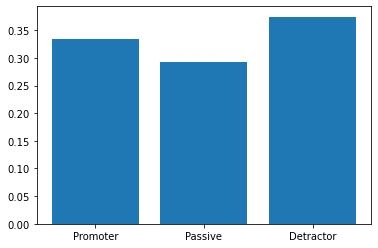

In [30]:
os.chdir('/users/suchanek/repos/npsML/data/clean')
os.listdir()
write_NPS_text_dataset('NPS_NATL_subset.csv')

In [48]:
#
os.chdir('/users/suchanek/repos/npsML/data/clean')

NPS_df = pd.read_csv('NPS_NATL_subset.csv', index_col='respid2', usecols=['respid2', 'NPS_Code', 'NPSCommentCleaned'])
y = NPS_df['NPS_Code'].values.tolist()
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

np.random.seed(42)
X_train_df, y_train_df, X_test_df, y_test_df = iterative_train_test_split_dataframe(NPS_df, labels, 0.5)


#NPS_df.head(5)


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
curr_dir = os.getcwd()
data_dir = "/users/suchanek/repos/npsml/data/clean"
class_list = ['detractor', 'passive', 'promoter']

os.chdir(data_dir)

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'npsdata/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'npsdata/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'npsdata/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25062 files belonging to 3 classes.
Using 20050 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-13 14:09:36.206805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-13 14:09:36.207254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25062 files belonging to 3 classes.
Using 5012 files for validation.
Found 5328 files belonging to 3 classes.


In [50]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Comment: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Comment: b'because they took days to look my computer\n'
Label : 1 (passive)
Comment: b'we had to drive miles to take my desktop to the best buy in denton can not send emails and webroot is not scanning my computer neither problem was resolved at the store now have to wait to have technician come to my house when we placed the original phone call we asked to have technician come to the house but we were told we needed to bring the computer to the store\n'
Label : 1 (passive)
Comment: b'they react like robots\n'
Label : 0 (detractor)


2022-07-13 14:11:21.540275: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-13 14:11:21.565884: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [51]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)